In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [2]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Complex/Interesting Cut Alteration Variants</h2>

In [4]:
variant_df_filtered = variant_df.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

#Filter on human variants
included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

filter_query = ""

for exp_index, included_experiment in enumerate(included_experiments) :
    filter_query += "experiment == '" + str(included_experiment) + "'"
    if exp_index < len(included_experiments) - 1 :
        filter_query += " or "

human_variant_df = variant_df.query(filter_query).copy()
human_variant_df_filtered = variant_df_filtered.query(filter_query).copy()

human_variant_df['delta_logodds_pred'] = human_variant_df['mean_delta_logodds_pred']
human_variant_df_filtered['delta_logodds_pred'] = human_variant_df_filtered['mean_delta_logodds_pred']


Interesting cut alteration examples:
Gene = TPM1.7
WT seq = GAACCTTGAACAGATACAACTAATTTACATATTACTAACCAAACTTAAACATTAAACTTTTTCTACTACTTTAAATTCTAACCTGGAATGTTTCAGAGTTCTTCATTCTAATATCACCCTGAATTCCATTGAAGCTGGAAATGTCATTTTCCAAGCCCACCTGT
SNV pos = 79
SNV nt = C
ClinVar id = Missing


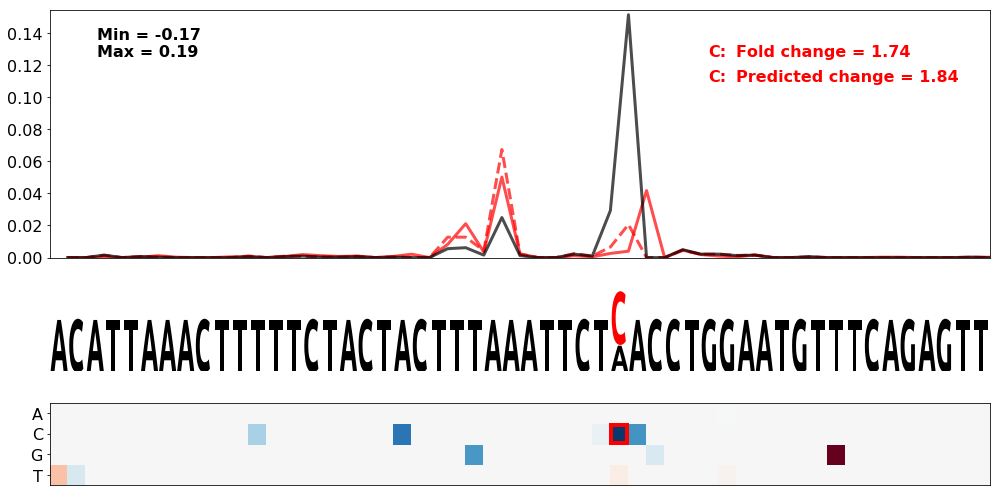

Gene = CPOX.2
WT seq = TATGATTTCTTTGTTCATATATTATGAATGTATTATTTTATTTGCTTCGTAATAAAGTTTATAAGGAAGAGCATCTCATACATATCATTATCGTGGAACACGTTGAATGTTTGTGATTCTGTGTGGCCTTTTTGGGGCTGGAAAATGTATGAATTCTTCAACTG
SNV pos = 77
SNV nt = G
ClinVar id = NM_000097.5(CPOX):c.*1105A>G


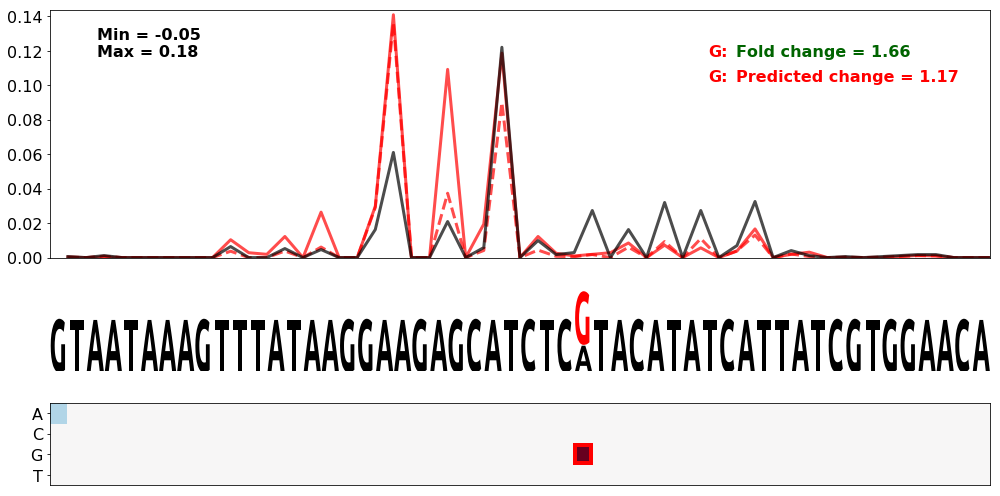

Gene = RYR2.5
WT seq = AGAAACAAGTTGATCAACGTGAGAGAAATTTCATGATAATTATTCATAGTAATAAAGTGTCGTGGGCTTAATTGTATATCTGGAGCCAGTGTCATCCACCAACAATGTGATACAATATGAACTTGACAGTAGTTTTGGGTTTTGCTCATTCTTTCAGCCACCTG
SNV pos = 75
SNV nt = G
ClinVar id = Missing


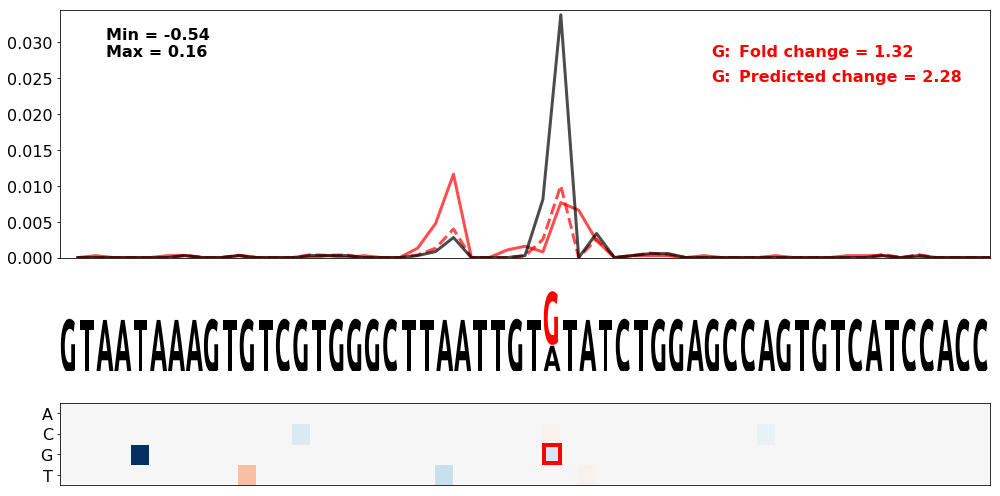

Gene = TGFBR2.6
WT seq = CACTGTAAACATTAGCTCTTTCCACTGCCTACCTGGACCCCAGTCTAGGAATTAAATCTGCACCTAACCAAGGTCCCTTGTAAGAAATGTCCATTCAAGCAGTCATTCTCTGGGTATATAATATGATTTTGACTACCTTATCTGGTGTTAAGATTTGAAGTTGG
SNV pos = 77
SNV nt = A
ClinVar id = Missing


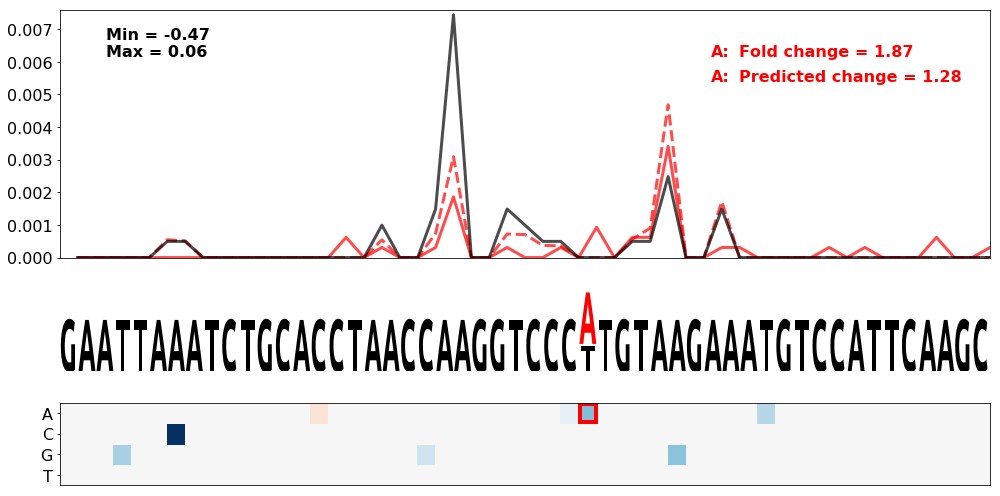

Gene = MSH2.1
WT seq = ACTGTTTGCAATTGACATAGGCAATAATAAGTGATGTGCTGAATTTTATAAATAAAATCATGTAGTTTGTGGAATTTGAGATGCATTGTAGTTCTTCGCAGTGTGACTTCAAATATTTTGGAAGAAACAAATAGCTCAGAGACCTCGTAAAATATCTTAAACTG
SNV pos = 72
SNV nt = G
ClinVar id = Missing


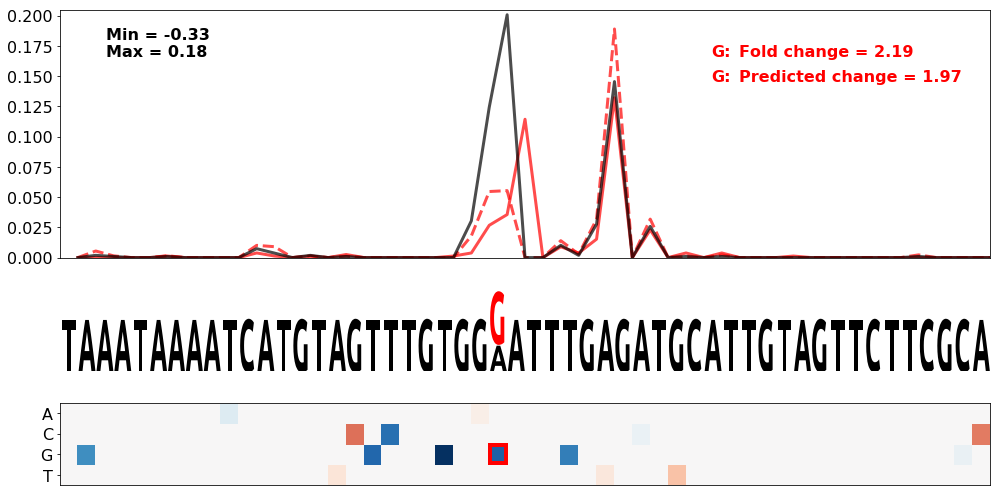

Gene = HBA2.2
WT seq = CTCCCAACGGGCCCTCCTCCCCTCCTTGCACCGGCCCTTCCTGGTCTTTGAATAAAGTCTGAGTGGGCAGCAGCCTGTGTGTGCCTGGGTTCTCTCTATCCCGGAATGTGCCAACAATGGAGGTGTTTACCTGTCTCAGACCAAGGACCTCTCTGCAGCTGCAT
SNV pos = 71
SNV nt = C
ClinVar id = Missing


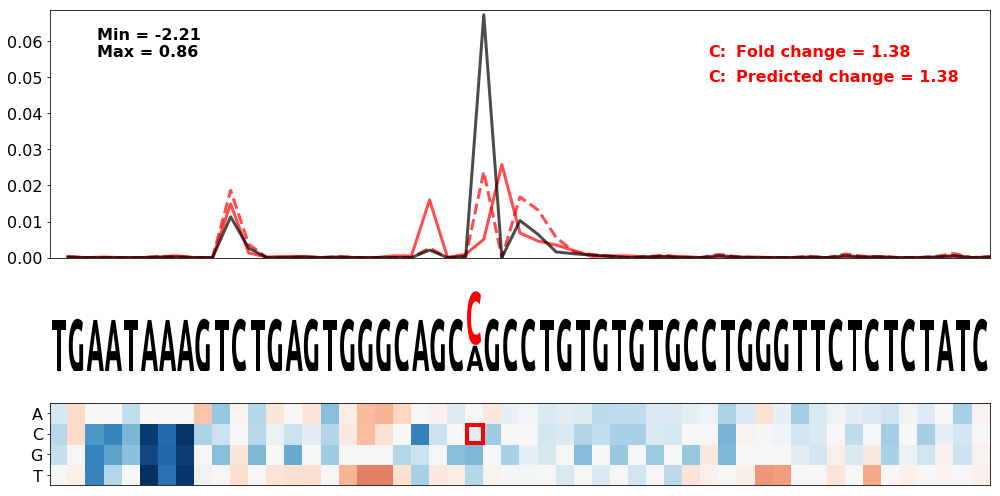

Gene = TP53.3
WT seq = CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG
SNV pos = 73
SNV nt = A
ClinVar id = Missing


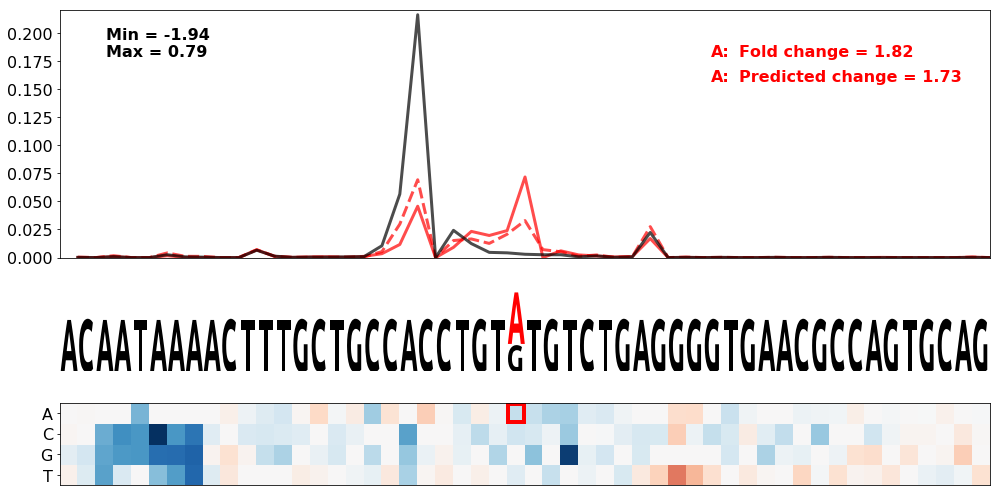

Gene = PRKAG2.2
WT seq = TGCAATTTTTTTACACATCTTTTGGTGGAGTAAACTTCACCACATCCATGAATAAACTCTCAGTTATTTTGAAATGGCAAATTTCTCATTATTTAAGTTTGGATCTGGAAAGGACATGACTTCTGAAATAGCCGCTGCTGGGTTTTAAAAGCTGAGGTCTCTCA
SNV pos = 76
SNV nt = A
ClinVar id = Missing


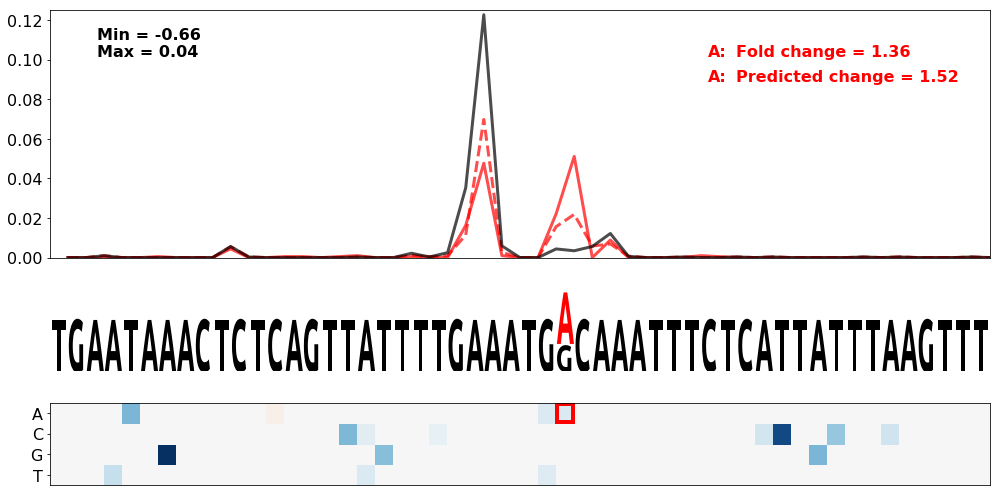

Gene = TP53.3
WT seq = CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG
SNV pos = 70
SNV nt = A
ClinVar id = Missing


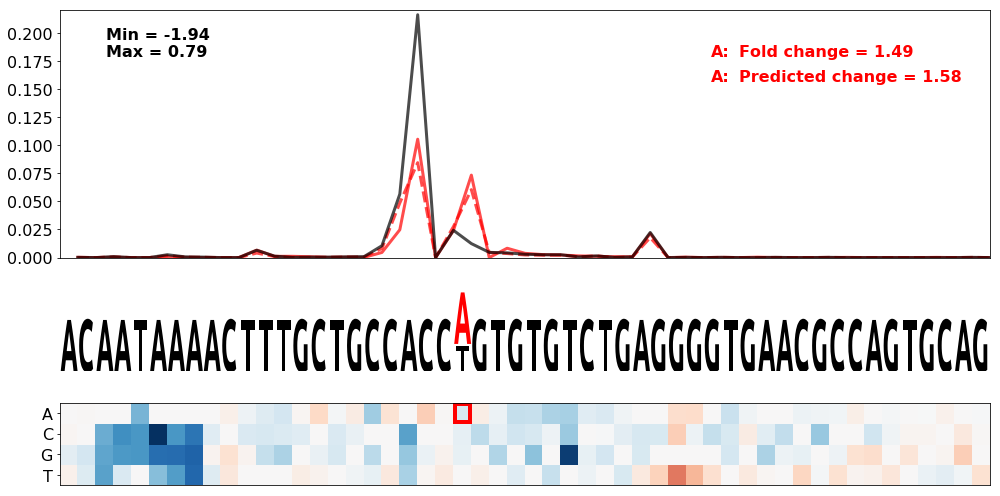

Gene = MRPS16.7
WT seq = GGTCCTTTTGAAACACTGCAGCGATCTTAATTTTGTTAGATTTGGAGTTCAATAAATGGAGTATCCTGAGTTGCCCTTGCTCTTCTGGCCTGGCCTGCACAGGGCCCAGGGAGAGATTTGTTCTTGTGTGACTTAGAGCTGGGTGTGGGTACTAATTAGCTTTT
SNV pos = 78
SNV nt = A
ClinVar id = NM_016065.3(MRPS16):c.*121G>A


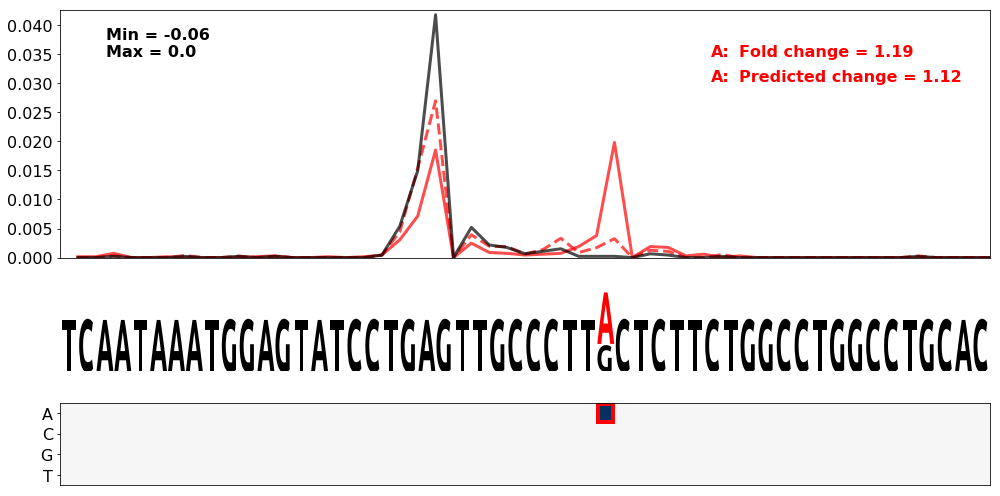

Gene = FOXC1.2
WT seq = TCTATCCTCTTTTCTTTCTTTTTGTTGAACATATTCATTGTTTGTTTATTAATAAATTACCATTCAGTTTGAATGAGACCTATATGTCTGGATACTTTAATAGAGCTTTAATTATTACGAAAAAAGATTTCAGAGATAAAACACTAGAAGTTACCTATTCTCCA
SNV pos = 68
SNV nt = A
ClinVar id = Missing


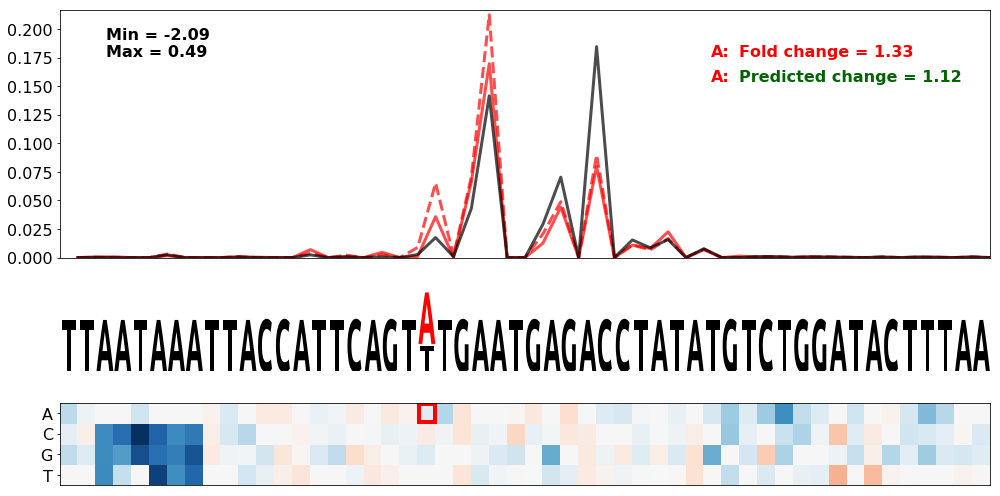

Gene = FOXC1.2
WT seq = TCTATCCTCTTTTCTTTCTTTTTGTTGAACATATTCATTGTTTGTTTATTAATAAATTACCATTCAGTTTGAATGAGACCTATATGTCTGGATACTTTAATAGAGCTTTAATTATTACGAAAAAAGATTTCAGAGATAAAACACTAGAAGTTACCTATTCTCCA
SNV pos = 77
SNV nt = G
ClinVar id = Missing


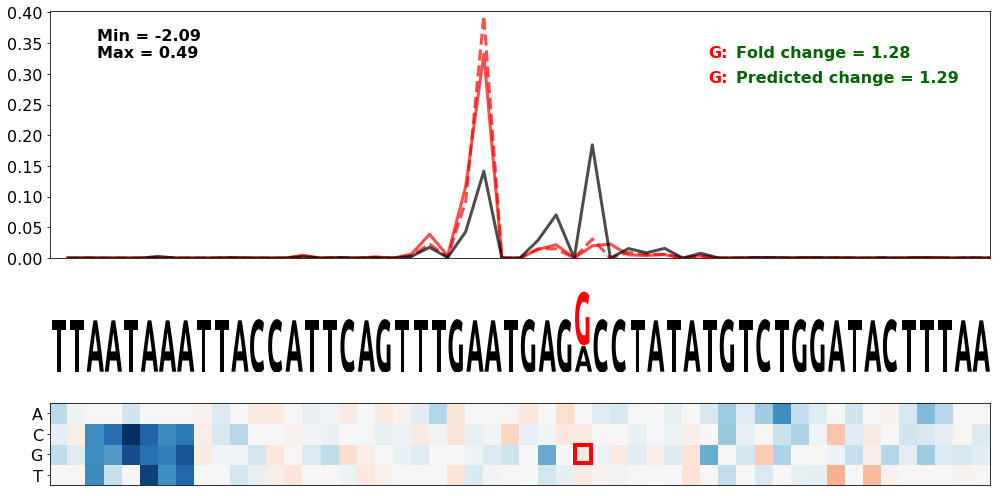

Gene = FOLR1.1
WT seq = CCCAACTATTTGGTTCCTGCTCCATGGTCGGGCCTCTGACAGCCACTTTGAATAAACCAGACACCGCACATGTGTCTTGAGAATTATTTGGATATGAATGGGAACGTGACTGTTTTGTTTTCCAATTCCCATTGATTGAAACCAGTGAGACTGGGCCAATTCCT
SNV pos = 67
SNV nt = G
ClinVar id = NM_016725.2(FOLR1):c.*122A>G


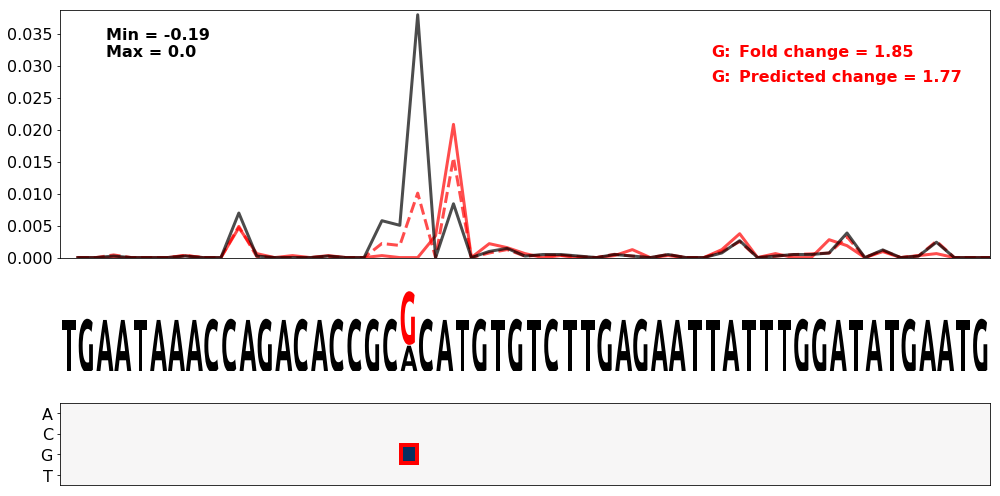

Gene = BRCA1.1
WT seq = ACTTGATTGTACAAAATACGTTTTGTAAATGTTGTGCTGTTAACACTGCAAATAAACTTGGTAGCAAACACTTCCACCATGAATGACTGTTCTTGAGACTTAGGCCAGCCGACTTTCTCAGAGCCTTTTCACTGTGCTTCAGTCTCCCACTCTGTAAAATGGGG
SNV pos = 71
SNV nt = A
ClinVar id = Missing


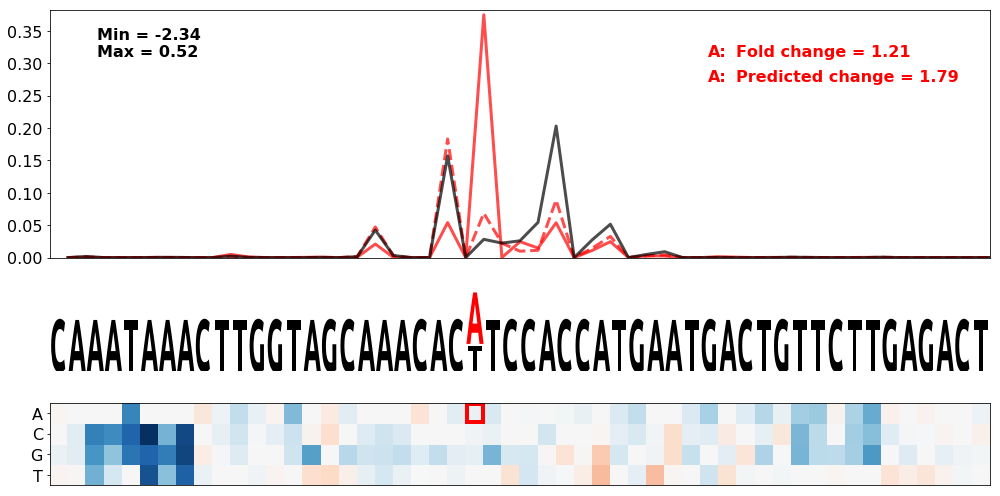

Gene = BRCA1.1
WT seq = ACTTGATTGTACAAAATACGTTTTGTAAATGTTGTGCTGTTAACACTGCAAATAAACTTGGTAGCAAACACTTCCACCATGAATGACTGTTCTTGAGACTTAGGCCAGCCGACTTTCTCAGAGCCTTTTCACTGTGCTTCAGTCTCCCACTCTGTAAAATGGGG
SNV pos = 72
SNV nt = A
ClinVar id = Missing


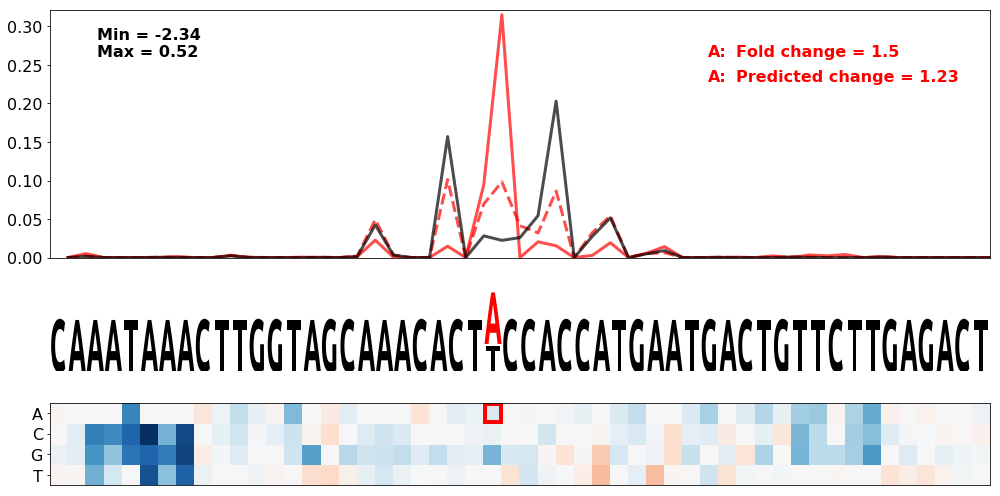

Gene = RB1.14
WT seq = ATAATTTACAGAAAGCTACAGAAATCATATTTACCAGGACACATCTGTTAAATAAAAGCATTGTTTCATGTTGGTGTACGTCTATACAGGGCTATGTATAACCGACTCCTGTTTCTCCTCCCTGCAACCACAGAACCATCACACACACACACACACACACACAC
SNV pos = 71
SNV nt = A
ClinVar id = Missing


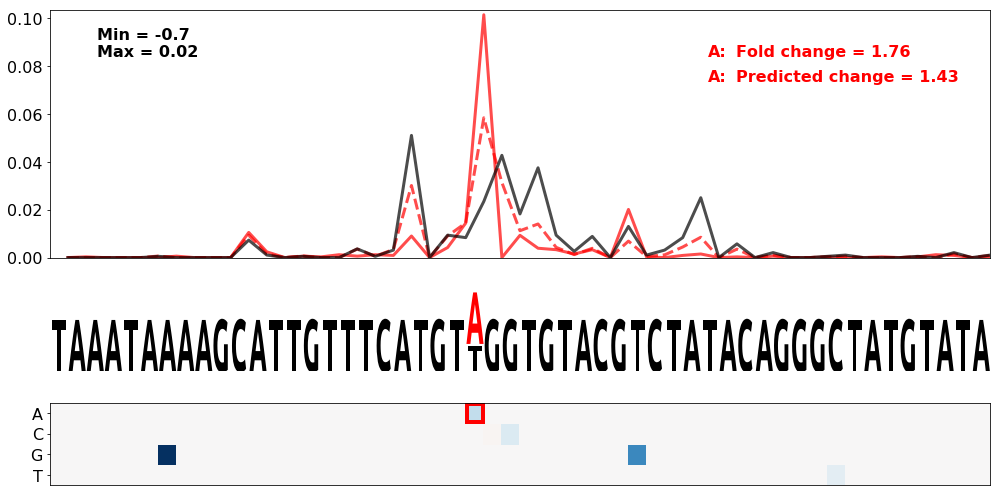

Gene = GLA.6
WT seq = AATCCCACAGGCACTGTTTTGCTTCAGCTAGAAAATACAATGCAGATGTCATTAAAAGACTTACTTTAAAATGTTTATTTTATTGCCAACTACTACTTCCTGTCCACCTTTTTCTCCATTCACTTTAAAAGCTCAAGGCTAGGTGGCTCATGCCTGTAATCCCA
SNV pos = 75
SNV nt = A
ClinVar id = Missing


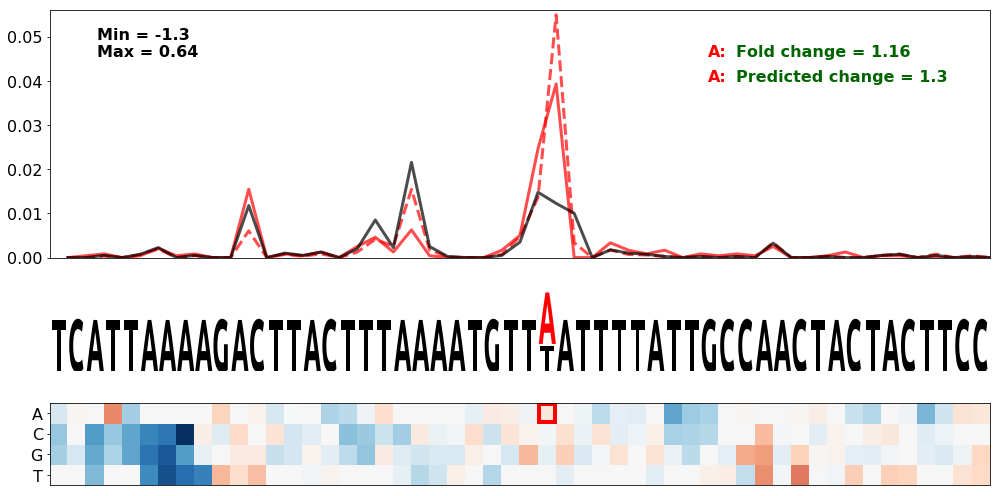

Gene = TPMT.3
WT seq = TACATTTTAATTAAACAATCTATATGGAACAAACATTCCCAAATTCTAAGAATAAATTTTTCTTTAAGTTTTCTCTGAGTTTGGCAATTGTTGTTTTTTATAATTTAATCTGTTTAAATCATCAGGTCTTATAAAATATAATGTACTTAGAGCTGGATTCATGG
SNV pos = 72
SNV nt = T
ClinVar id = Missing


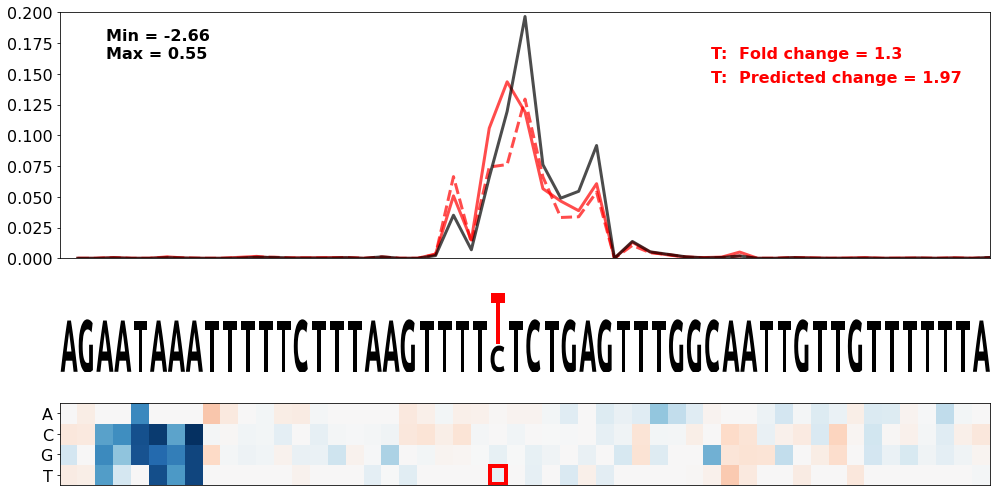

Gene = ARSA.1
WT seq = GCTAACCCAGTGTCTCCAGCTGCCTACCTGGAGAGCTCCAAGCGTAAGAAAATAAACCCTGCCTGTTGAAGCCACTGCTAGTGAGGGTTCTGTTATTTGCAGCCAAAAGCCTTGCTGGAATGTGGCCTATGAATGGTTGTGTGGCGGGCACATGTGCCTGCGTG
SNV pos = 75
SNV nt = A
ClinVar id = Missing


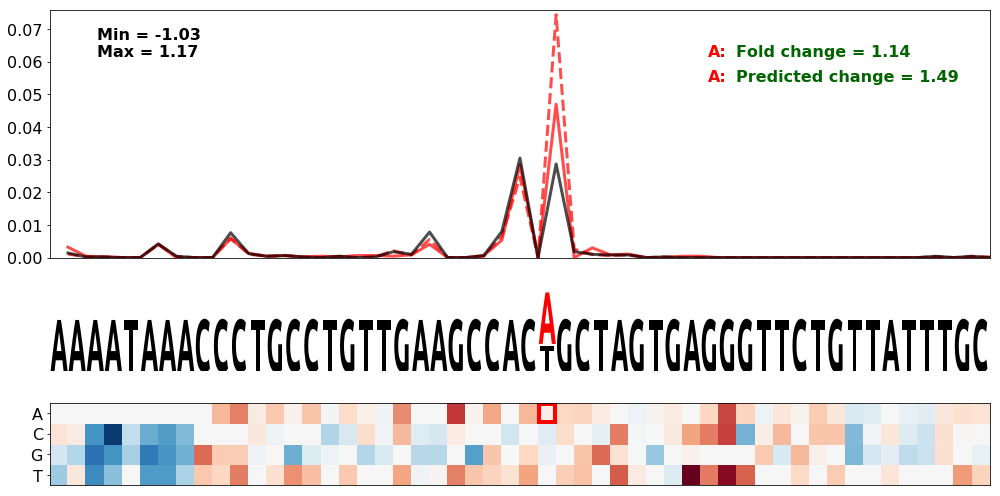

Gene = ARSA.1
WT seq = GCTAACCCAGTGTCTCCAGCTGCCTACCTGGAGAGCTCCAAGCGTAAGAAAATAAACCCTGCCTGTTGAAGCCACTGCTAGTGAGGGTTCTGTTATTTGCAGCCAAAAGCCTTGCTGGAATGTGGCCTATGAATGGTTGTGTGGCGGGCACATGTGCCTGCGTG
SNV pos = 73
SNV nt = T
ClinVar id = Missing


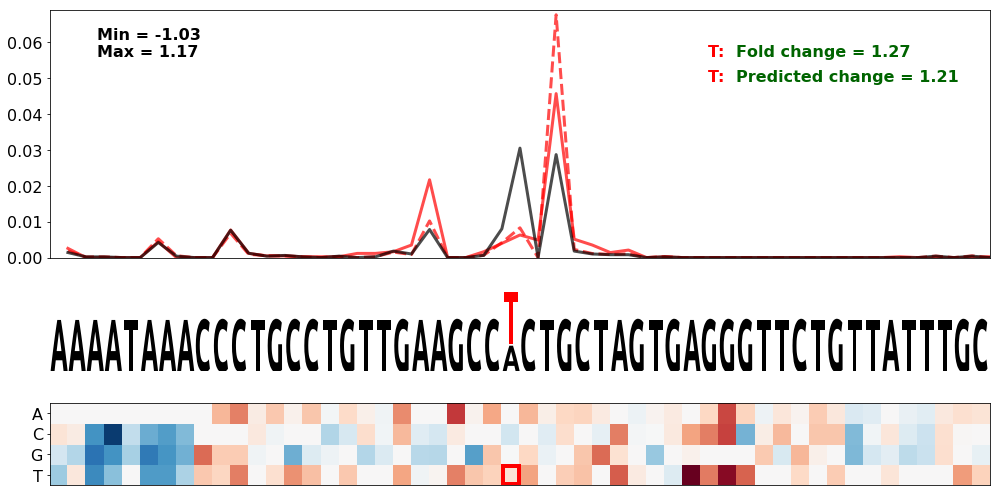

Gene = ARSA.1
WT seq = GCTAACCCAGTGTCTCCAGCTGCCTACCTGGAGAGCTCCAAGCGTAAGAAAATAAACCCTGCCTGTTGAAGCCACTGCTAGTGAGGGTTCTGTTATTTGCAGCCAAAAGCCTTGCTGGAATGTGGCCTATGAATGGTTGTGTGGCGGGCACATGTGCCTGCGTG
SNV pos = 73
SNV nt = C
ClinVar id = Missing


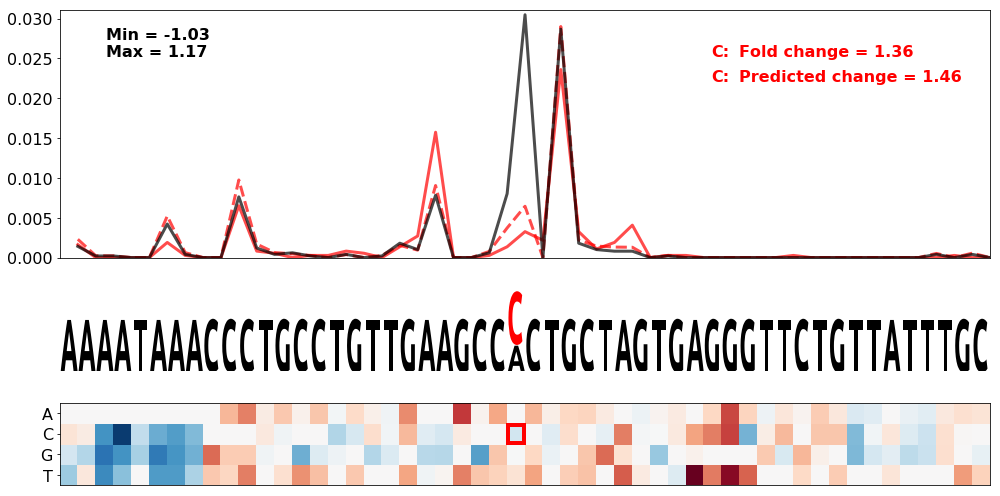

In [5]:
print('Interesting cut alteration examples:')

experiment_name = 'cut_alteration'

gene_names = [
    'TPM1.7',
    'CPOX.2',
    'RYR2.5',
    'TGFBR2.6',
    'MSH2.1',
    'HBA2.2',
    'TP53.3',
    'PRKAG2.2',
    'TP53.3',
    'MRPS16.7',
    'FOXC1.2',
    'FOXC1.2',
    'FOLR1.1',
    'BRCA1.1',
    'BRCA1.1',
    'RB1.14',
    'GLA.6',
    'TPMT.3',
    'ARSA.1',
    'ARSA.1',
    'ARSA.1'
]

snv_list = [
    [(79, 'C', 'red')],
    [(77, 'G', 'red')],
    [(75, 'G', 'red')],
    [(77, 'A', 'red')],
    [(72, 'G', 'red')],
    [(71, 'C', 'red')],
    [(73, 'A', 'red')],
    [(76, 'A', 'red')],
    [(70, 'A', 'red')],
    [(78, 'A', 'red')],
    [(68, 'A', 'red')],
    [(77, 'G', 'red')],
    [(67, 'G', 'red')],
    [(71, 'A', 'red')],
    [(72, 'A', 'red')],
    [(71, 'A', 'red')],
    [(75, 'A', 'red')],
    [(72, 'T', 'red')],
    [(75, 'A', 'red')],
    [(73, 'T', 'red')],
    [(73, 'C', 'red')]
]

wt_seq_list = [
    'GAACCTTGAACAGATACAACTAATTTACATATTACTAACCAAACTTAAACATTAAACTTTTTCTACTACTTTAAATTCTAACCTGGAATGTTTCAGAGTTCTTCATTCTAATATCACCCTGAATTCCATTGAAGCTGGAAATGTCATTTTCCAAGCCCACCTGT',
    'TATGATTTCTTTGTTCATATATTATGAATGTATTATTTTATTTGCTTCGTAATAAAGTTTATAAGGAAGAGCATCTCATACATATCATTATCGTGGAACACGTTGAATGTTTGTGATTCTGTGTGGCCTTTTTGGGGCTGGAAAATGTATGAATTCTTCAACTG',
    'AGAAACAAGTTGATCAACGTGAGAGAAATTTCATGATAATTATTCATAGTAATAAAGTGTCGTGGGCTTAATTGTATATCTGGAGCCAGTGTCATCCACCAACAATGTGATACAATATGAACTTGACAGTAGTTTTGGGTTTTGCTCATTCTTTCAGCCACCTG',
    'CACTGTAAACATTAGCTCTTTCCACTGCCTACCTGGACCCCAGTCTAGGAATTAAATCTGCACCTAACCAAGGTCCCTTGTAAGAAATGTCCATTCAAGCAGTCATTCTCTGGGTATATAATATGATTTTGACTACCTTATCTGGTGTTAAGATTTGAAGTTGG',
    'ACTGTTTGCAATTGACATAGGCAATAATAAGTGATGTGCTGAATTTTATAAATAAAATCATGTAGTTTGTGGAATTTGAGATGCATTGTAGTTCTTCGCAGTGTGACTTCAAATATTTTGGAAGAAACAAATAGCTCAGAGACCTCGTAAAATATCTTAAACTG',
    'CTCCCAACGGGCCCTCCTCCCCTCCTTGCACCGGCCCTTCCTGGTCTTTGAATAAAGTCTGAGTGGGCAGCAGCCTGTGTGTGCCTGGGTTCTCTCTATCCCGGAATGTGCCAACAATGGAGGTGTTTACCTGTCTCAGACCAAGGACCTCTCTGCAGCTGCAT',
    'CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG',
    'TGCAATTTTTTTACACATCTTTTGGTGGAGTAAACTTCACCACATCCATGAATAAACTCTCAGTTATTTTGAAATGGCAAATTTCTCATTATTTAAGTTTGGATCTGGAAAGGACATGACTTCTGAAATAGCCGCTGCTGGGTTTTAAAAGCTGAGGTCTCTCA',
    'CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG',
    'GGTCCTTTTGAAACACTGCAGCGATCTTAATTTTGTTAGATTTGGAGTTCAATAAATGGAGTATCCTGAGTTGCCCTTGCTCTTCTGGCCTGGCCTGCACAGGGCCCAGGGAGAGATTTGTTCTTGTGTGACTTAGAGCTGGGTGTGGGTACTAATTAGCTTTT',
    'TCTATCCTCTTTTCTTTCTTTTTGTTGAACATATTCATTGTTTGTTTATTAATAAATTACCATTCAGTTTGAATGAGACCTATATGTCTGGATACTTTAATAGAGCTTTAATTATTACGAAAAAAGATTTCAGAGATAAAACACTAGAAGTTACCTATTCTCCA',
    'TCTATCCTCTTTTCTTTCTTTTTGTTGAACATATTCATTGTTTGTTTATTAATAAATTACCATTCAGTTTGAATGAGACCTATATGTCTGGATACTTTAATAGAGCTTTAATTATTACGAAAAAAGATTTCAGAGATAAAACACTAGAAGTTACCTATTCTCCA',
    'CCCAACTATTTGGTTCCTGCTCCATGGTCGGGCCTCTGACAGCCACTTTGAATAAACCAGACACCGCACATGTGTCTTGAGAATTATTTGGATATGAATGGGAACGTGACTGTTTTGTTTTCCAATTCCCATTGATTGAAACCAGTGAGACTGGGCCAATTCCT',
    'ACTTGATTGTACAAAATACGTTTTGTAAATGTTGTGCTGTTAACACTGCAAATAAACTTGGTAGCAAACACTTCCACCATGAATGACTGTTCTTGAGACTTAGGCCAGCCGACTTTCTCAGAGCCTTTTCACTGTGCTTCAGTCTCCCACTCTGTAAAATGGGG',
    'ACTTGATTGTACAAAATACGTTTTGTAAATGTTGTGCTGTTAACACTGCAAATAAACTTGGTAGCAAACACTTCCACCATGAATGACTGTTCTTGAGACTTAGGCCAGCCGACTTTCTCAGAGCCTTTTCACTGTGCTTCAGTCTCCCACTCTGTAAAATGGGG',
    'ATAATTTACAGAAAGCTACAGAAATCATATTTACCAGGACACATCTGTTAAATAAAAGCATTGTTTCATGTTGGTGTACGTCTATACAGGGCTATGTATAACCGACTCCTGTTTCTCCTCCCTGCAACCACAGAACCATCACACACACACACACACACACACAC',
    'AATCCCACAGGCACTGTTTTGCTTCAGCTAGAAAATACAATGCAGATGTCATTAAAAGACTTACTTTAAAATGTTTATTTTATTGCCAACTACTACTTCCTGTCCACCTTTTTCTCCATTCACTTTAAAAGCTCAAGGCTAGGTGGCTCATGCCTGTAATCCCA',
    'TACATTTTAATTAAACAATCTATATGGAACAAACATTCCCAAATTCTAAGAATAAATTTTTCTTTAAGTTTTCTCTGAGTTTGGCAATTGTTGTTTTTTATAATTTAATCTGTTTAAATCATCAGGTCTTATAAAATATAATGTACTTAGAGCTGGATTCATGG',
    'GCTAACCCAGTGTCTCCAGCTGCCTACCTGGAGAGCTCCAAGCGTAAGAAAATAAACCCTGCCTGTTGAAGCCACTGCTAGTGAGGGTTCTGTTATTTGCAGCCAAAAGCCTTGCTGGAATGTGGCCTATGAATGGTTGTGTGGCGGGCACATGTGCCTGCGTG',
    'GCTAACCCAGTGTCTCCAGCTGCCTACCTGGAGAGCTCCAAGCGTAAGAAAATAAACCCTGCCTGTTGAAGCCACTGCTAGTGAGGGTTCTGTTATTTGCAGCCAAAAGCCTTGCTGGAATGTGGCCTATGAATGGTTGTGTGGCGGGCACATGTGCCTGCGTG',
    'GCTAACCCAGTGTCTCCAGCTGCCTACCTGGAGAGCTCCAAGCGTAAGAAAATAAACCCTGCCTGTTGAAGCCACTGCTAGTGAGGGTTCTGTTATTTGCAGCCAAAAGCCTTGCTGGAATGTGGCCTATGAATGGTTGTGTGGCGGGCACATGTGCCTGCGTG'
]

seq_start = 48
seq_end = 100

save_figs = False

for gene_name, snvs, specific_seq in zip(gene_names, snv_list, wt_seq_list) :
    df_sel = human_variant_df.copy().set_index('master_seq')
    if specific_seq is not None :
        df_sel = human_variant_df.query("wt_seq == '" + specific_seq + "'").copy().set_index('master_seq')

    df_sel['delta_logodds_pred'] = df_sel['mean_delta_logodds_pred']
    
    print('Gene = ' + gene_name)
    print('WT seq = ' + specific_seq)
    print('SNV pos = ' + str(snvs[0][0]))
    print('SNV nt = ' + str(snvs[0][1]))
    print('ClinVar id = ' + str(df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['clinvar_id'].values[0]))
    
    fig_name = None
    if save_figs :
        fig_name = experiment_name + '_' + gene_name + '_' + str(snvs[0][0]) + '_' + str(snvs[0][1]) + '_Both'
    mut_map_with_cuts(
            df_sel,
            gene_name,
            snvs,
            mode='true',
            column_suffix='',
            figsize=(14, 7),
            height_ratios=[6, 2, 2],
            bg_alpha=0.999,
            plot_simple_mutmap=True,
            annotate_folds=True,
            plot_true_cuts=True,
            plot_pred_cuts=True,
            scale_pred_cuts=True,
            fold_change_from_cut_range=[60, 90],
            ref_var_scales=[0.5, 1.0],
            border_eta = 0.06,
            seq_trim_start=seq_start, seq_trim_end=seq_end,
            plot_start=0, plot_end=seq_end-seq_start,
            plot_as_bars=False,
            pas_downscaling=0.5,
            fig_name=fig_name,
            fig_dpi=150
    )